## ReadCSV and preprocess

In [3]:
library(dplyr)
library(readr)
library(rjags)

In [4]:
# Read your data
df <- read_csv("data.csv")

# Create team indices (important for modeling)
teams <- sort(unique(c(df$home_team, df$away_team)))
team_index <- setNames(seq_along(teams), teams)

df <- df %>%
  mutate(
    H = team_index[home_team],
    A = team_index[away_team]
  )


Rows: 1230 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): game_date, home_team, away_team
dbl (12): game_id, fg3m_home, ftm_home, pts_home, fg3m_away, ftm_away, pts_a...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Model in JAGS for winning probability

In [11]:
model_string_wp <- "
model {
  for (i in 1:N) { # for each game
    # Home
    d[i] ~ dbern(pi[i]) # if home team wins
    logit(pi[i]) <- str[H[i]] - str[A[i]] + eta
    
    # Away
    # AFT[i] ~ dpois(thetaA[i])
    # log(thetaA[i]) <- att[A[i]] + def[H[i]] + c
  }

  # Priors
  for (j in 1:K) { # for each team
    str[j] ~ dnorm(mu, tau)
  }

  mu ~ dnorm(0, 0.0001)
  tau ~ dgamma(0.1, 0.1)
  eta ~ dnorm(0,0.0001)


  # Identifiability constraints
  str[K+1] <- -sum(str[1:(K-1)])
  # def[K+1] <- -sum(def[1:(K-1)]) 
}
"

## Prepare data for rjags

In [12]:
# Assume you've already processed your DataFrame as above
data_list <- list(
  N = nrow(df),
  K = length(teams)-1,
  d = df$home_win,
  H = df$H,
  A = df$A
)

# Run model
model <- jags.model(textConnection(model_string_wp), data = data_list, n.chains = 3)
update(model, 5000)  # Burn-in

samples_wp <- coda.samples(model, variable.names = c("str", "eta"), n.iter = 1000)
summary(samples_wp)


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1230
   Unobserved stochastic nodes: 32
   Total graph size: 6340

Initializing model




Iterations = 6001:7000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean      SD Naive SE Time-series SE
eta      0.56827 0.06796 0.001241       0.001662
str[1]   0.34853 0.22855 0.004173       0.007458
str[2]   1.22028 0.25043 0.004572       0.008592
str[3]  -0.31700 0.22740 0.004152       0.007443
str[4]   0.01395 0.22115 0.004038       0.006977
str[5]   1.45219 0.28372 0.005180       0.011348
str[6]   0.49711 0.22692 0.004143       0.007423
str[7]   0.71791 0.24503 0.004474       0.008448
str[8]  -0.09050 0.23038 0.004206       0.007713
str[9]  -0.65377 0.22969 0.004193       0.007402
str[10]  0.66725 0.23100 0.004218       0.007878
str[11] -0.22441 0.22714 0.004147       0.006682
str[12] -1.23156 0.26011 0.004749       0.009111
str[13]  1.37689 0.26729 0.004880       0.009657
str[14] -0.89699 0.24138 0.004407       0.007953
str[15]  0.14555 0.

In [13]:
coda::gelman.diag(samples_wp)  # > 1.1, problem with posterior

Potential scale reduction factors:

        Point est. Upper C.I.
eta           1.00       1.00
str[1]        1.00       1.01
str[2]        1.00       1.00
str[3]        1.00       1.01
str[4]        1.00       1.00
str[5]        1.00       1.01
str[6]        1.00       1.01
str[7]        1.00       1.00
str[8]        1.00       1.01
str[9]        1.01       1.01
str[10]       1.00       1.00
str[11]       1.00       1.00
str[12]       1.00       1.00
str[13]       1.00       1.02
str[14]       1.01       1.02
str[15]       1.00       1.01
str[16]       1.00       1.00
str[17]       1.00       1.01
str[18]       1.00       1.00
str[19]       1.00       1.00
str[20]       1.00       1.01
str[21]       1.00       1.01
str[22]       1.00       1.00
str[23]       1.00       1.00
str[24]       1.00       1.01
str[25]       1.00       1.00
str[26]       1.00       1.01
str[27]       1.00       1.00
str[28]       1.00       1.00
str[29]       1.00       1.00
str[30]       1.00       1.00

Mul

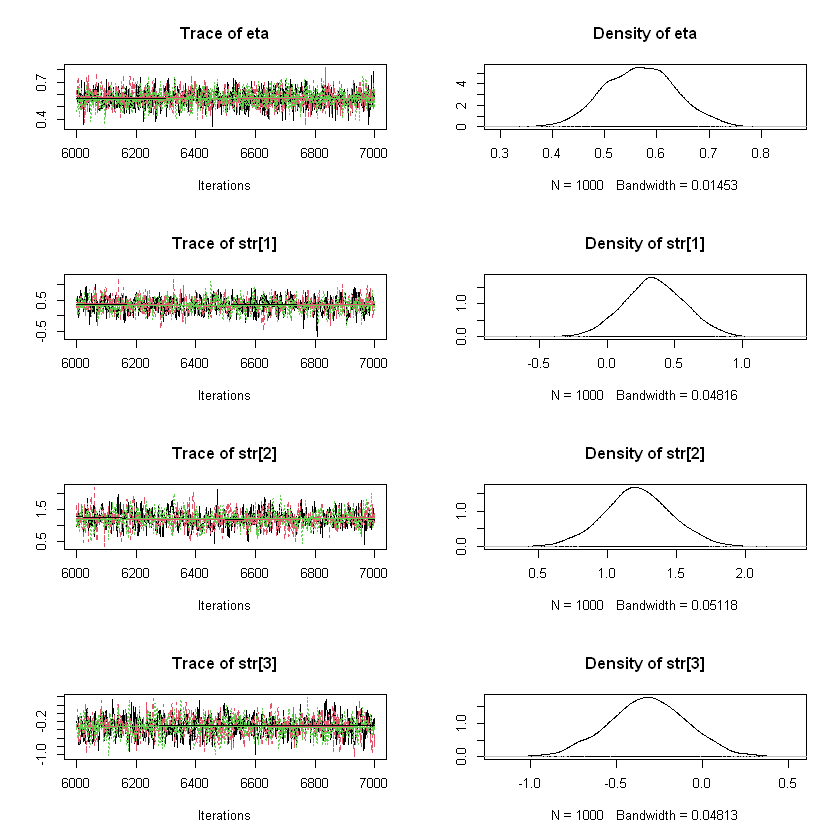

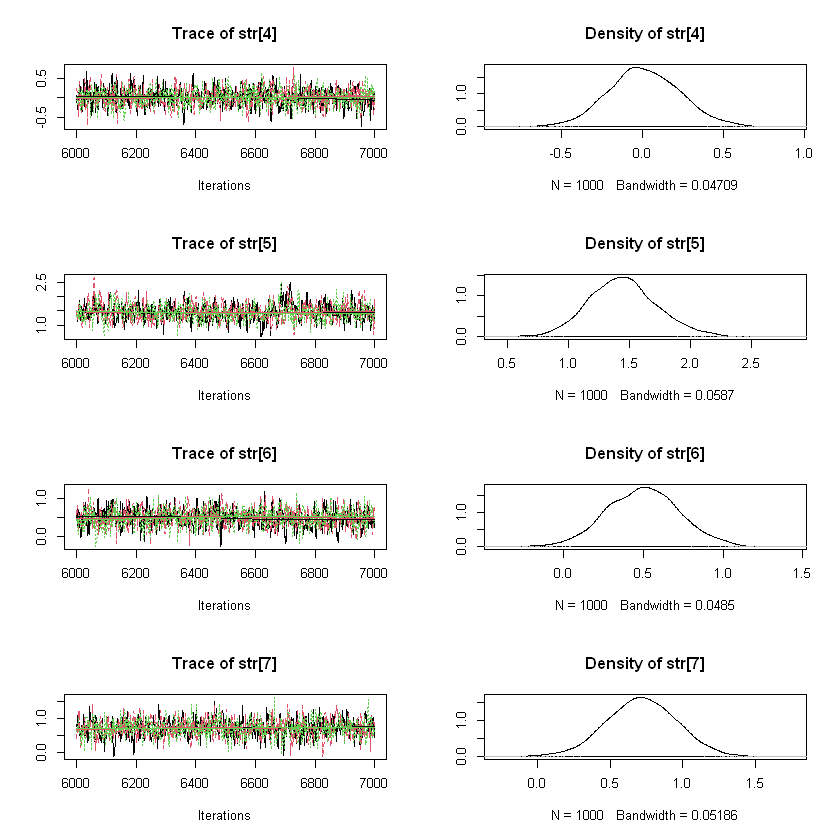

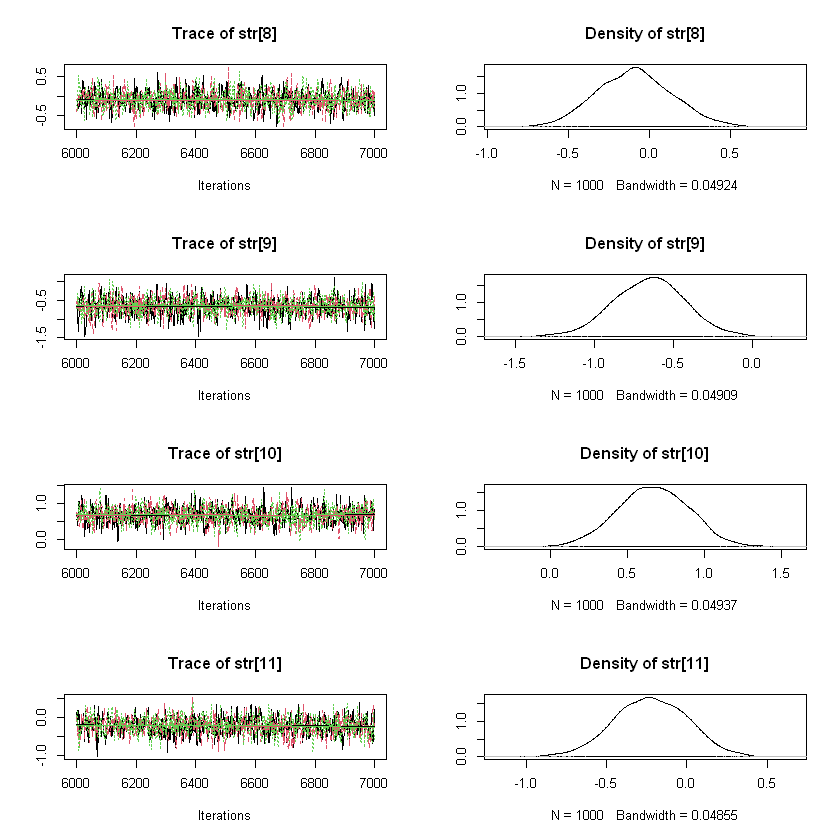

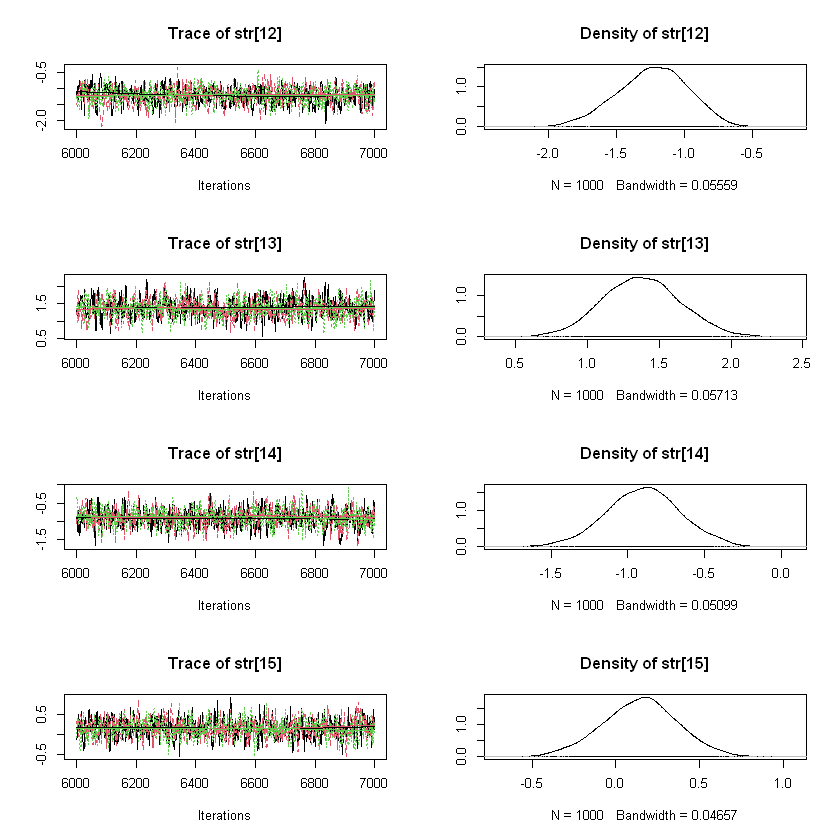

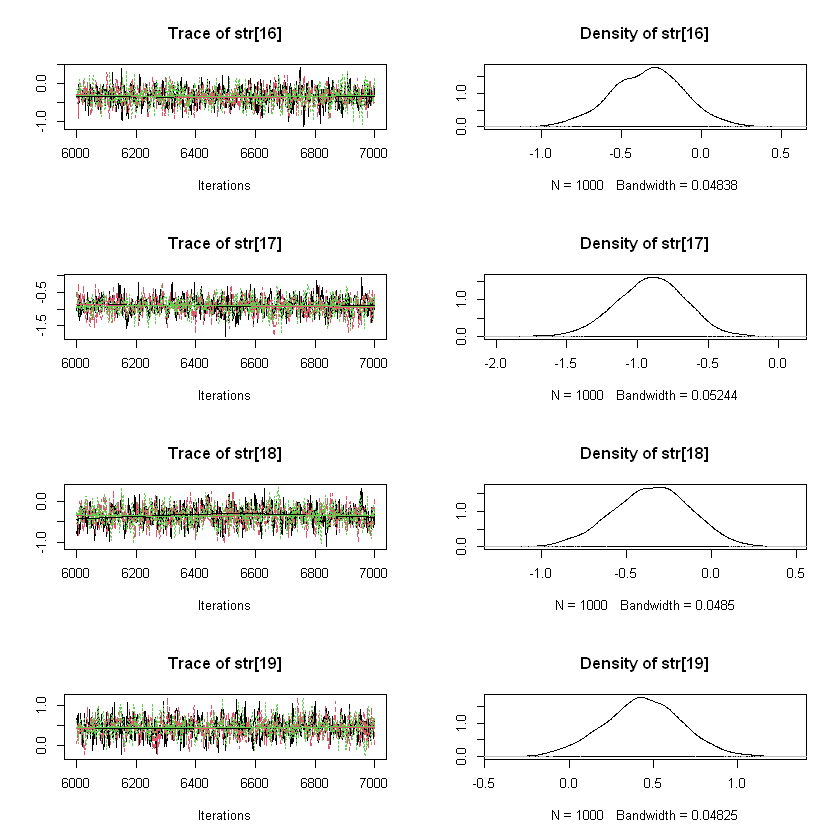

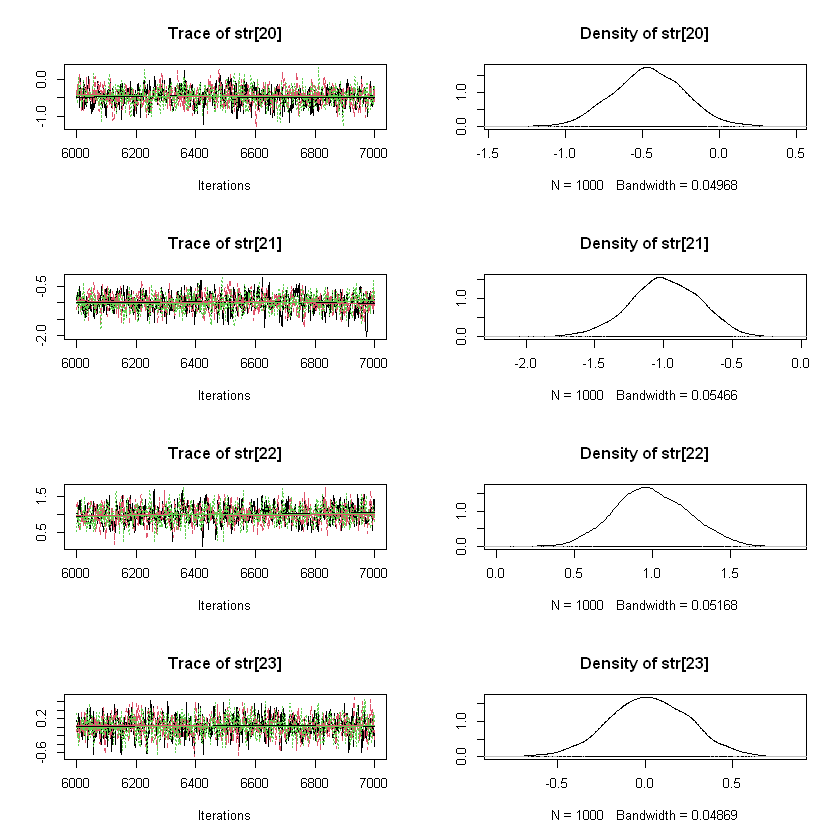

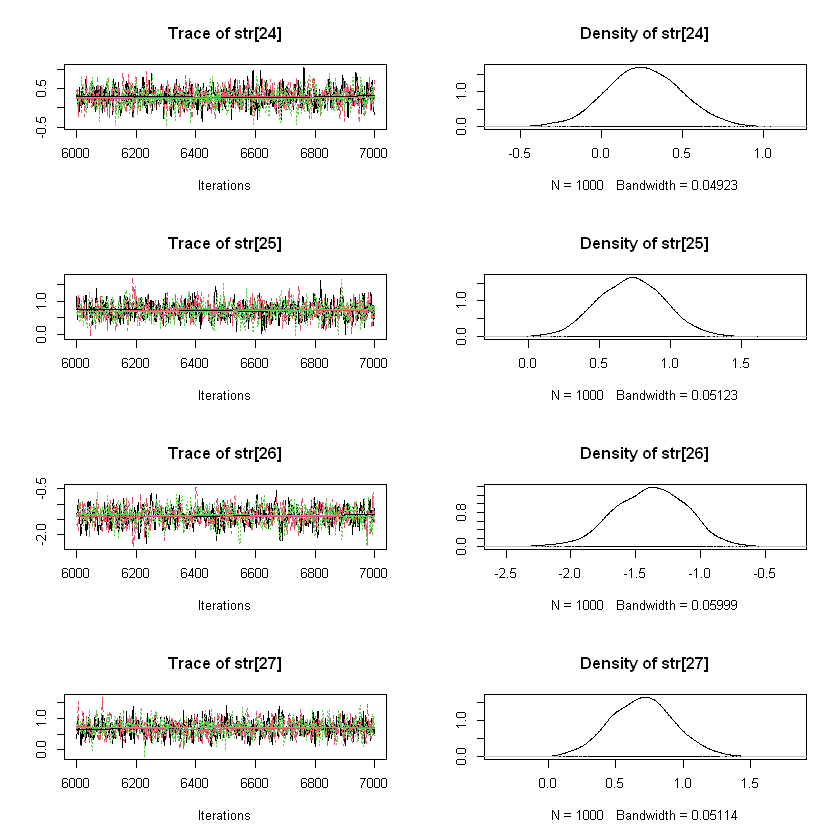

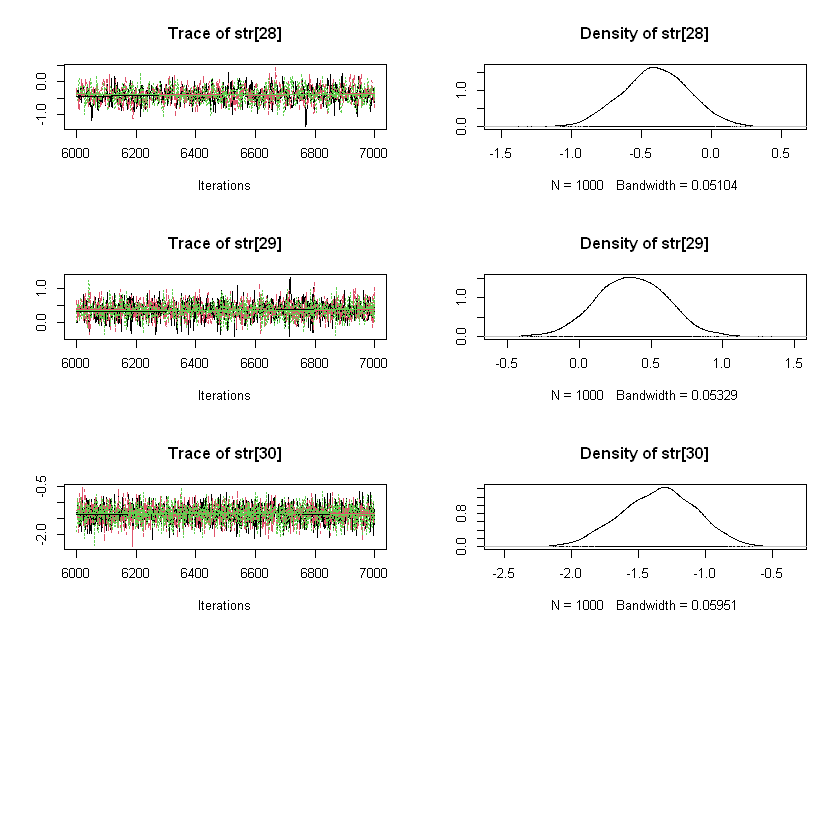

In [14]:
par(bg = 'white')
#fig.dim = c(8, 6)
plot(samples_wp)


In [20]:
N = nrow(df)
K = length(teams)

mean_str <- summary(samples_wp)$statistics[2]

for (i in 2:K+1){
    mean_str <- c(mean_str, summary(samples_wp)$statistics[i])
}


eta_val <- summary(samples_wp)$statistics[1]



In [23]:
length(mean_str)

[1] 30

In [24]:
write.csv(mean_str, 'WP_str.csv')
write.csv(eta_val, 'WP_eta.csv')
